# Single-cell Analysis Workflow: 90k brain cells example
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working RAPIDS environment with all nessaray dependencies.  In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

Let's start by ensuring that we have our dataset downloaded.

In [3]:
import os
import wget

url = 'https://figshare.com/ndownloader/files/45788454'
data_dir = "./h5"
final = data_dir+'/adata.raw.h5ad'
if not os.path.exists(data_dir): # Check if h5 directory exists
    print('creating data directory')
    os.system('mkdir ./h5')
else:
    print(f'{data_dir} directory found')

if not os.path.isfile(final): # Check to see if we have our final output.  If it is there, get to the analysis!
    print('Downloading cell data..')
    wget.download(url, final)
else:
    print(f'{final} dataset found')

./h5 directory found


We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read(final)

CPU times: user 2.39 s, sys: 403 ms, total: 2.79 s
Wall time: 2.79 s


In [6]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 45.1 ms, sys: 535 ms, total: 580 ms
Wall time: 580 ms


In [7]:
adata.shape

(93575, 33694)

Verify the shape of the resulting sparse matrix:

In [8]:
adata.shape

(93575, 33694)

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 3.3915634155273438


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 6.58 ms, sys: 0 ns, total: 6.58 ms
Wall time: 6.44 ms


In [12]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 6.35 ms, sys: 0 ns, total: 6.35 ms
Wall time: 5.99 ms


In [13]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 31.5 ms, sys: 10.6 ms, total: 42.1 ms
Wall time: 41.4 ms


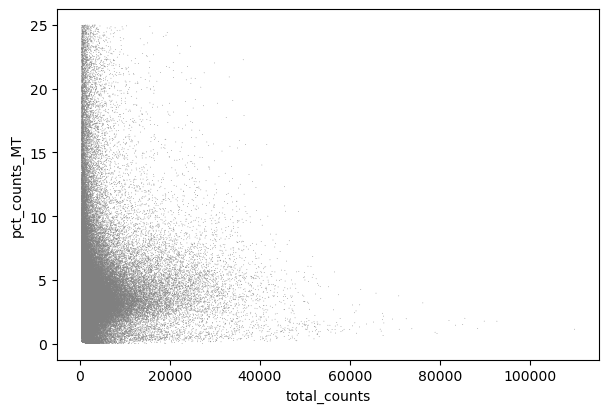

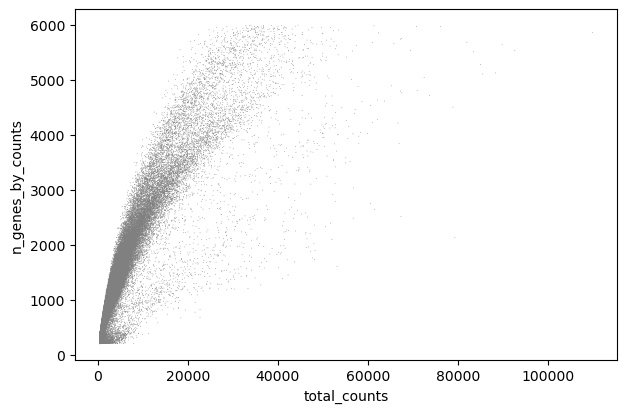

In [14]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

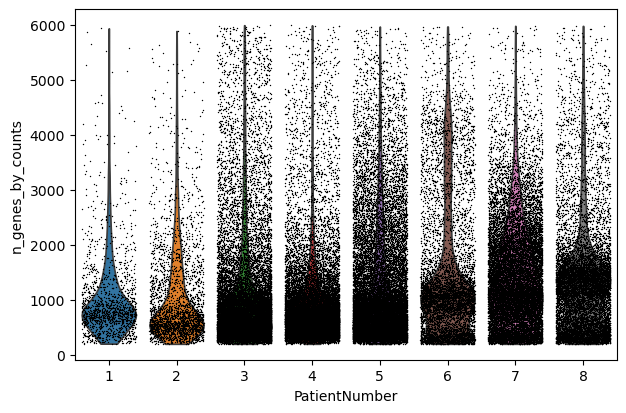

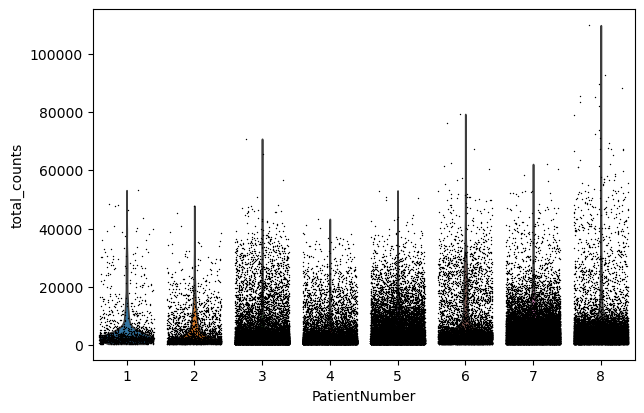

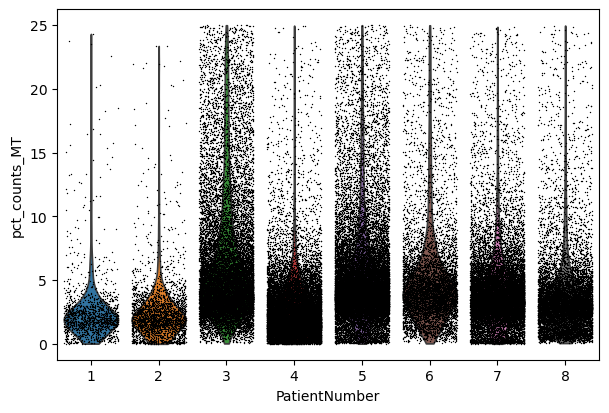

In [15]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="PatientNumber")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [17]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] > 200]
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata.shape

CPU times: user 24.7 ms, sys: 4.24 ms, total: 28.9 ms
Wall time: 28.5 ms


(92666, 33694)

In [18]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20]
adata.shape

CPU times: user 14.4 ms, sys: 870 μs, total: 15.2 ms
Wall time: 14.6 ms


(91180, 33694)

We also filter out genes that are expressed in less than 3 cells.

In [19]:
%%time
rsc.pp.filter_genes(adata, min_cells=3)

filtered out 8329 genes that are detected in less than 3 cells
CPU times: user 122 ms, sys: 31.4 ms, total: 154 ms
Wall time: 153 ms


We store the raw expression counts in the `.layer["counts"]`

In [20]:
adata.layers["counts"] = adata.X.copy()

In [21]:
adata.shape

(91180, 25365)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [22]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 772 μs, sys: 285 μs, total: 1.06 ms
Wall time: 1.08 ms


Next, we log transform the count matrix.

In [23]:
%%time
rsc.pp.log1p(adata)

CPU times: user 1.17 ms, sys: 432 μs, total: 1.6 ms
Wall time: 1.03 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [24]:
%%time
rsc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    flavor="seurat_v3",
    batch_key="PatientNumber",
    layer="counts",
)

CPU times: user 1.63 s, sys: 155 ms, total: 1.78 s
Wall time: 1.78 s


Now we safe this version of the AnnData as adata.raw.

In [25]:
%%time
adata.raw = adata

CPU times: user 18.9 ms, sys: 58.3 ms, total: 77.2 ms
Wall time: 76 ms


Now we restrict our AnnData object to the highly variable genes.

In [26]:
%%time
adata = adata[:, adata.var["highly_variable"]]

CPU times: user 34.7 ms, sys: 59.4 ms, total: 94.2 ms
Wall time: 93.5 ms


In [27]:
adata.shape

(91180, 5000)

Next we regress out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [28]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 1.46 s, sys: 210 ms, total: 1.67 s
Wall time: 1.68 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [29]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 142 ms, sys: 431 μs, total: 143 ms
Wall time: 142 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [30]:
%%time
rsc.pp.pca(adata, n_comps=100)

CPU times: user 500 ms, sys: 75.8 ms, total: 576 ms
Wall time: 575 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

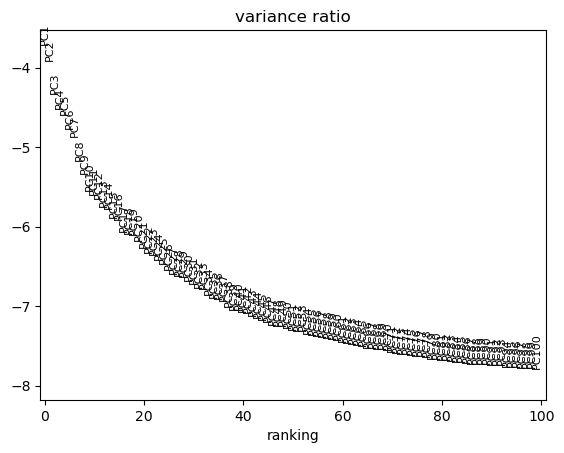

In [31]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [32]:
%%time
rsc.get.anndata_to_CPU(adata, convert_all=True)

CPU times: user 103 ms, sys: 83.7 ms, total: 186 ms
Wall time: 186 ms


In [33]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 65.76857233047485


We have now finished the preprocessing of the data.

## Batch Correction

In [34]:
%%time
rsc.pp.harmony_integrate(adata, key="PatientNumber", dtype = cp.float32)

CPU times: user 2.31 s, sys: 75.5 ms, total: 2.38 s
Wall time: 2.4 s


## Clustering and Visualization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the exact graph. Both methods are valid, but you might see differences.

In [35]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 229 ms, sys: 147 ms, total: 376 ms
Wall time: 376 ms


Next we calculate the UMAP embedding using rapdis.

In [36]:
%%time
rsc.tl.umap(adata)

CPU times: user 87.7 ms, sys: 64.8 ms, total: 153 ms
Wall time: 169 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [37]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 573 ms, sys: 91.9 ms, total: 665 ms
Wall time: 664 ms


In [38]:
%%time
rsc.tl.leiden(adata, resolution=0.6)

CPU times: user 303 ms, sys: 12.9 ms, total: 316 ms
Wall time: 322 ms


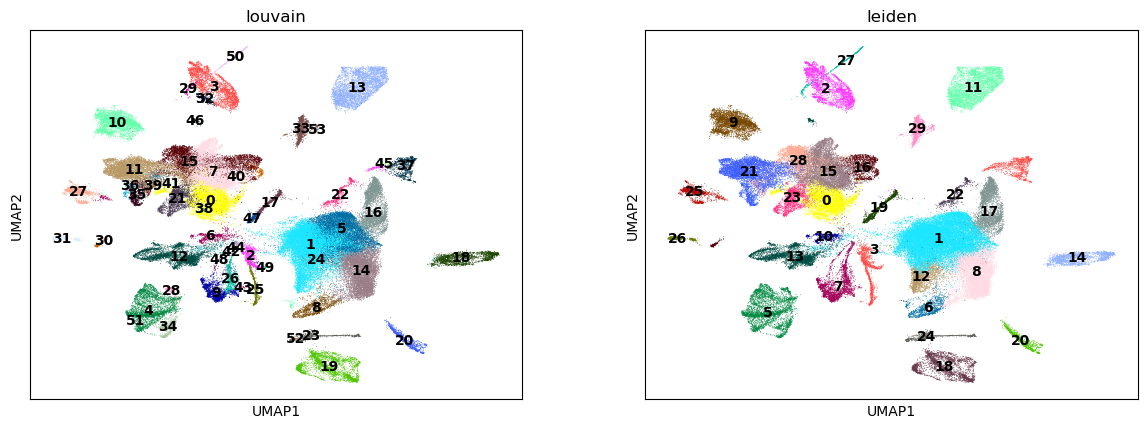

CPU times: user 626 ms, sys: 171 ms, total: 797 ms
Wall time: 611 ms


In [39]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

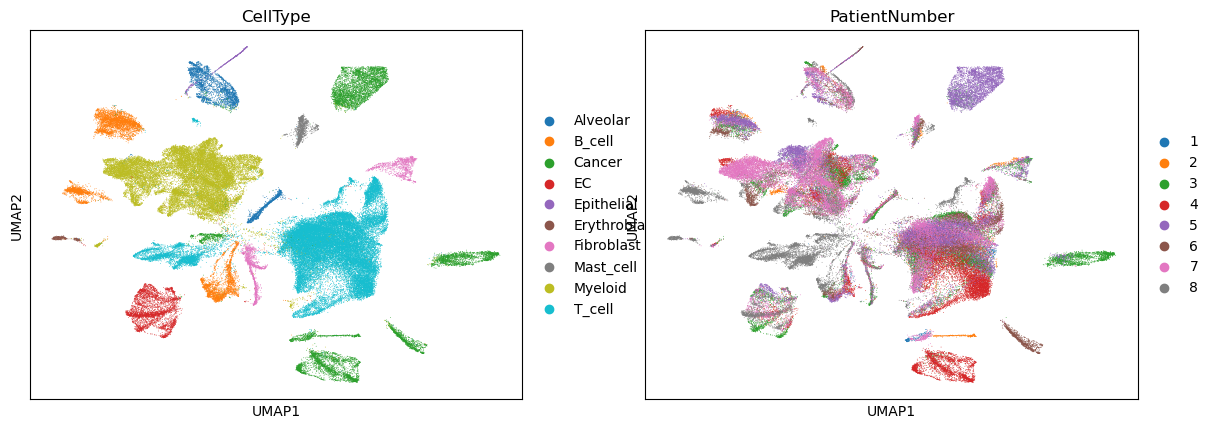

In [40]:
sc.pl.umap(adata, color=["CellType", "PatientNumber"])

We also calculate the embedding density in the UMAP using cuML

In [41]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 1.7 s, sys: 64 ms, total: 1.77 s
Wall time: 2.08 s


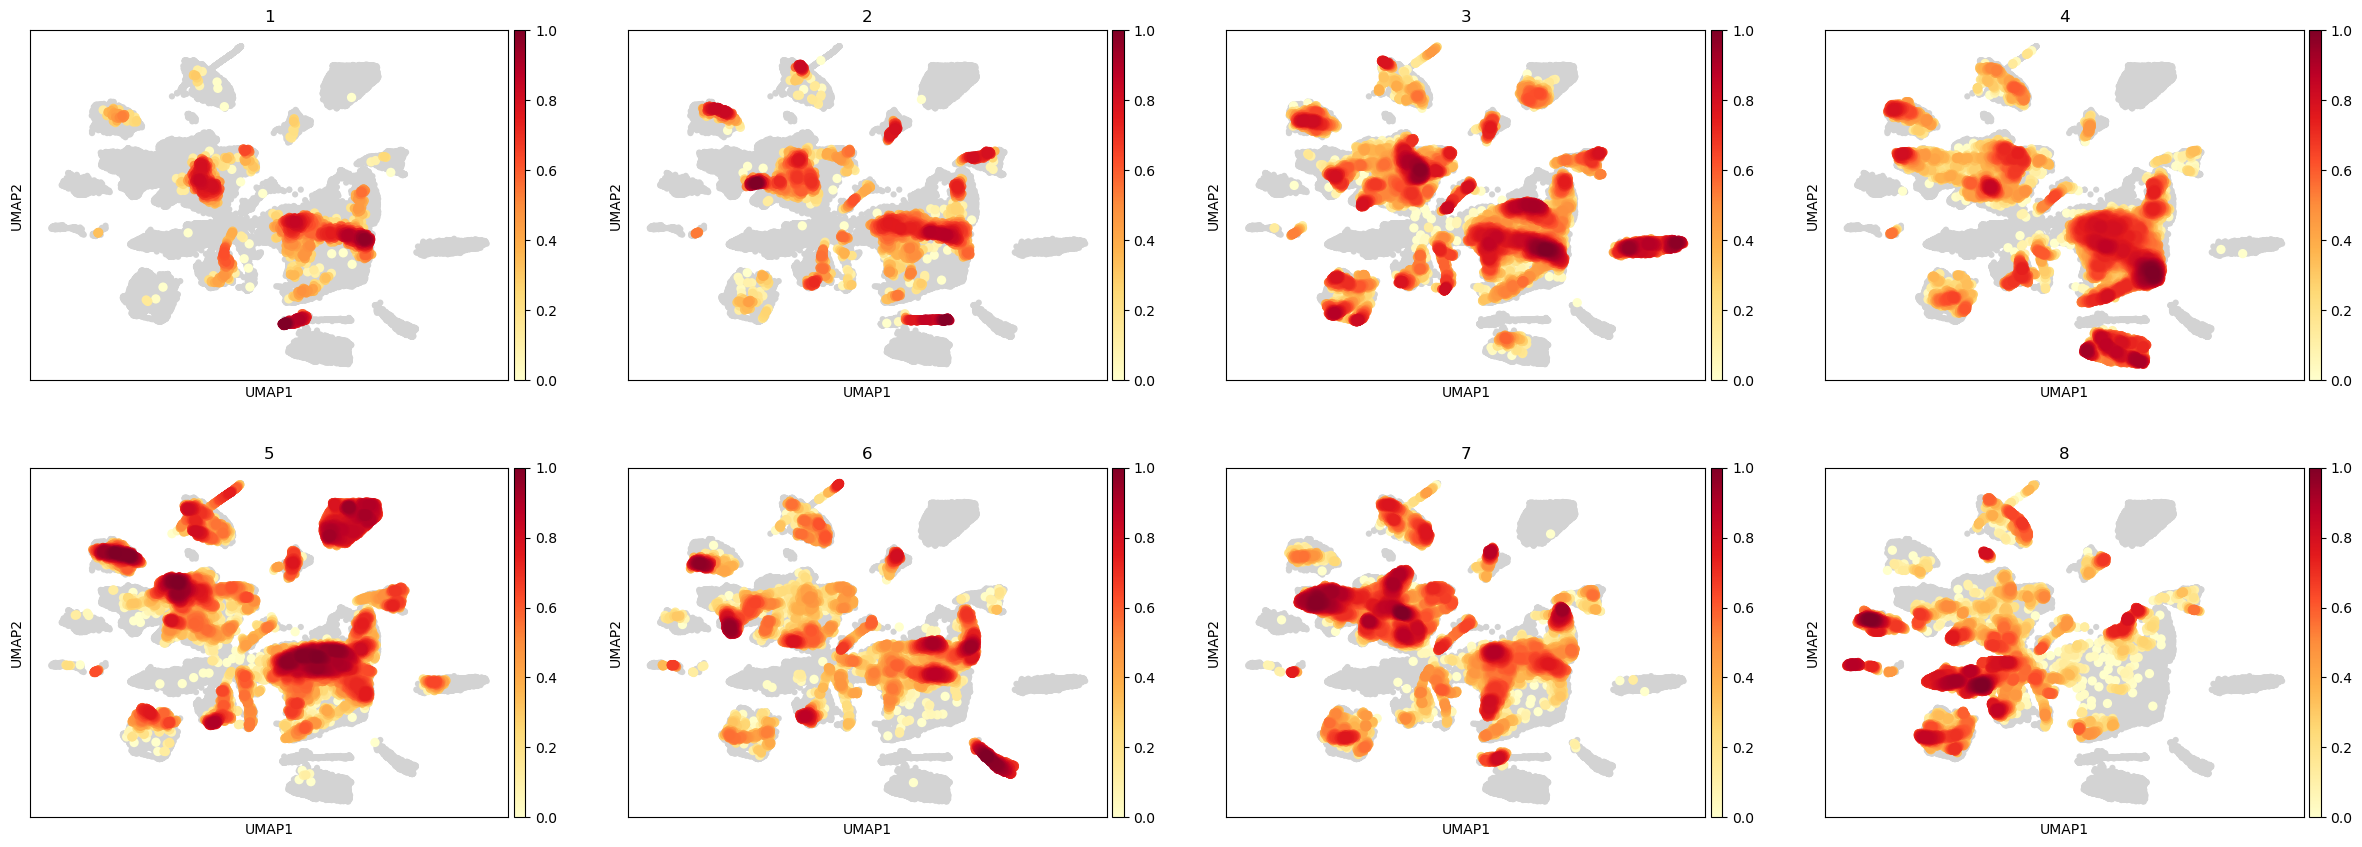

In [42]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [43]:
%%time
rsc.tl.tsne(adata, n_pcs=40)

[W] [19:22:34.650769] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 532 ms, sys: 690 ms, total: 1.22 s
Wall time: 1.22 s


In [44]:
rsc.tl.kmeans(adata, n_clusters=8)

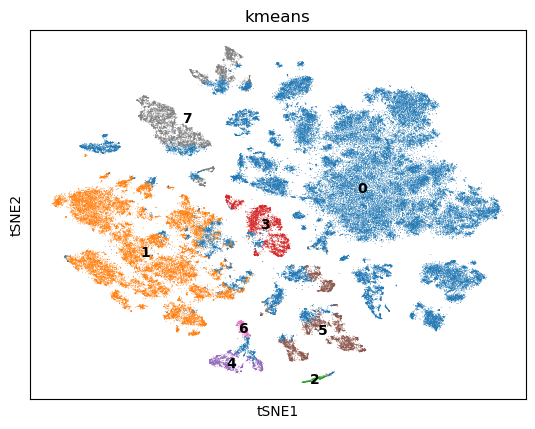

CPU times: user 303 ms, sys: 175 ms, total: 478 ms
Wall time: 292 ms


In [45]:
%%time
sc.pl.tsne(adata, color=["kmeans"], legend_loc="on data")

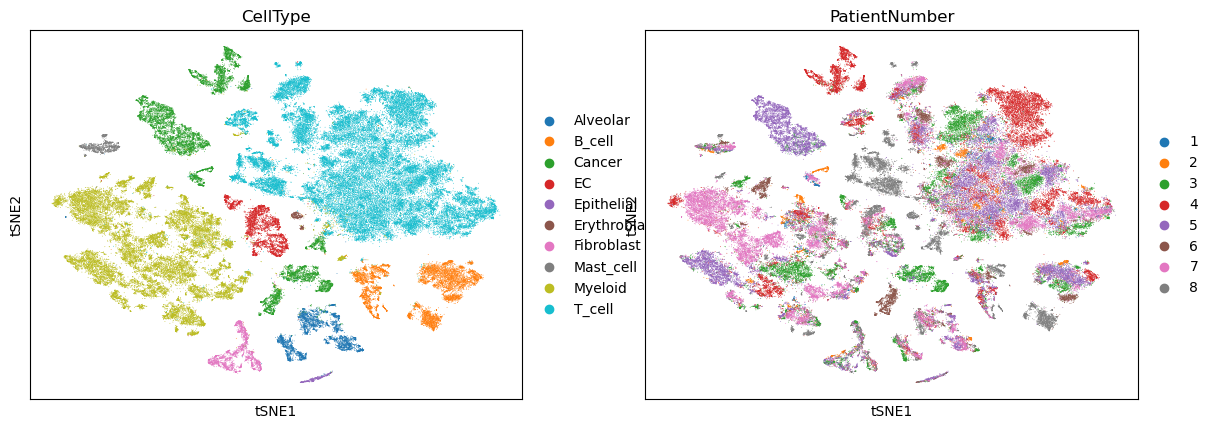

In [46]:
sc.pl.tsne(adata, color=["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [47]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.28 s, sys: 2.1 s, total: 4.38 s
Wall time: 4.38 s


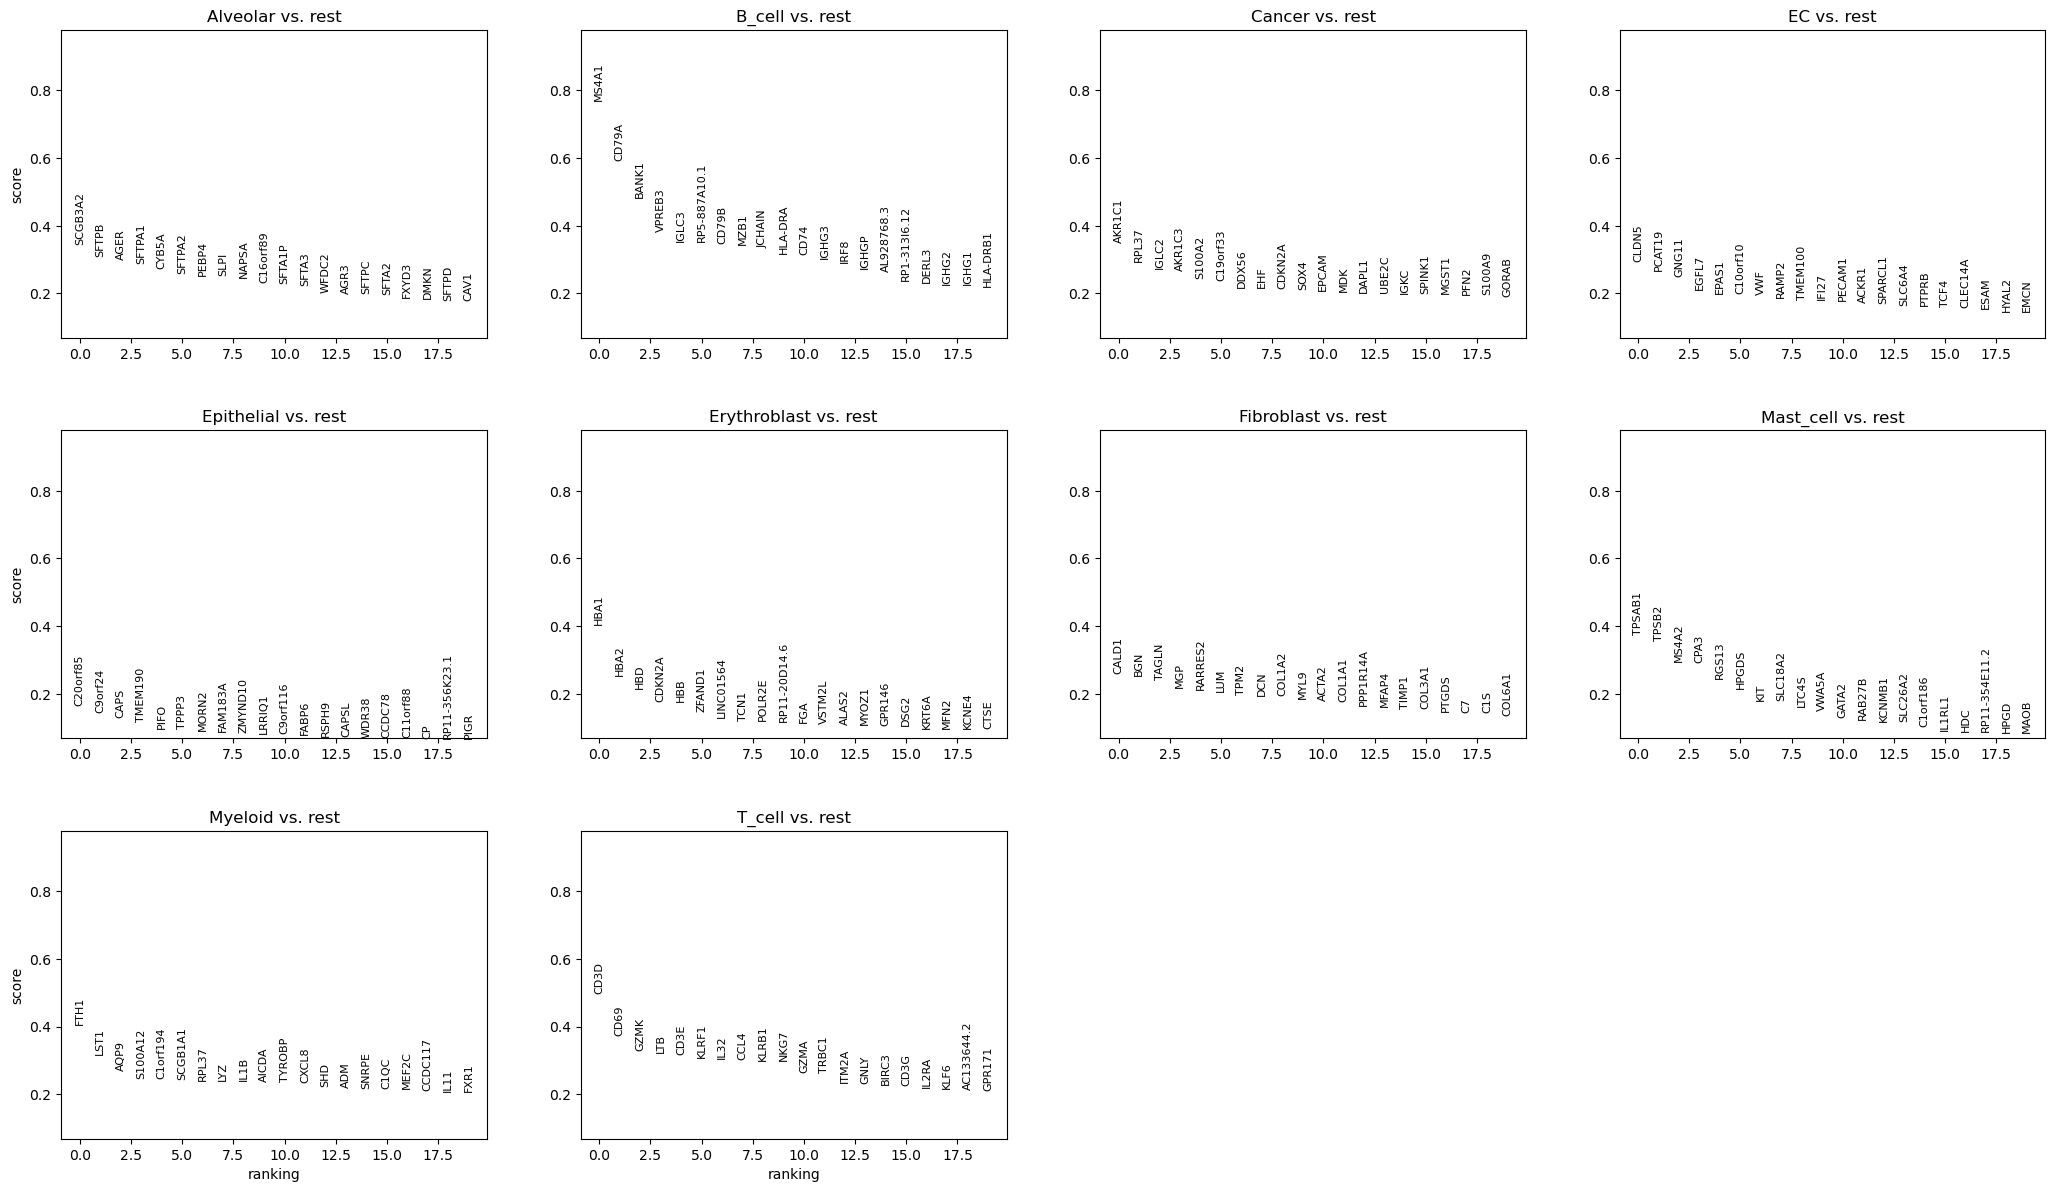

CPU times: user 725 ms, sys: 180 ms, total: 905 ms
Wall time: 720 ms


In [48]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [49]:
post_time = time.time()

In [50]:
print("Total Postprocessing time: %s" % (post_time - preprocess_time))

Total Postprocessing time: 17.440301179885864


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [51]:
tdata = adata[adata.obs["CellType"] == "T_cell", :].copy()

We can repeat the dimension reduction, clustering and visulatization.

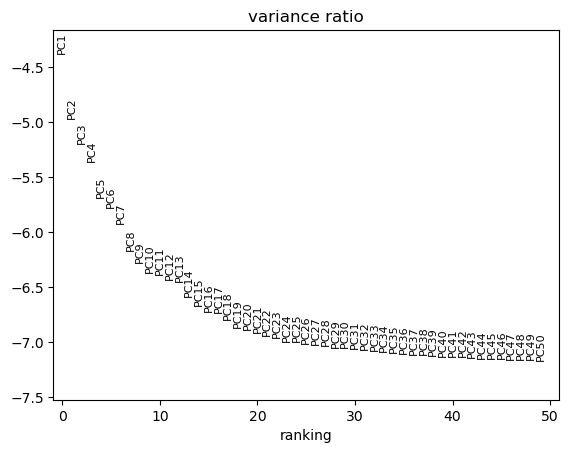

CPU times: user 614 ms, sys: 736 ms, total: 1.35 s
Wall time: 1.16 s


In [52]:
%%time
rsc.tl.pca(tdata, n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True, n_pcs=50)

In [53]:
%%time
rsc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata, key_added="louvain_subset") 

CPU times: user 257 ms, sys: 2.91 ms, total: 260 ms
Wall time: 259 ms


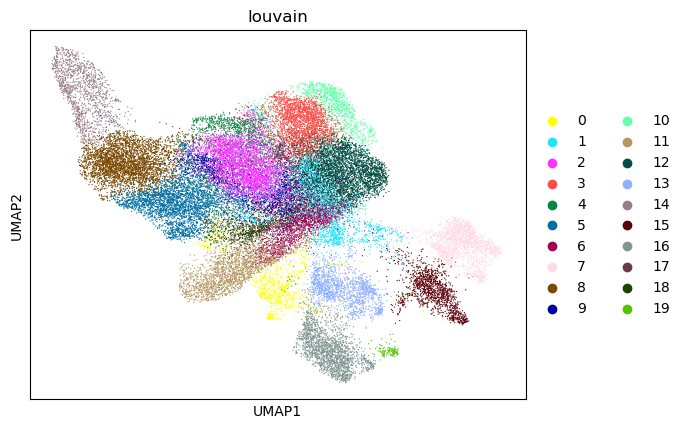

In [54]:
sc.pl.umap(tdata, color=["louvain_subset"])

As stated before Diffusion Maps have become an integral part of single cell analysis.

In [55]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 116 ms, sys: 6.68 ms, total: 123 ms
Wall time: 135 ms


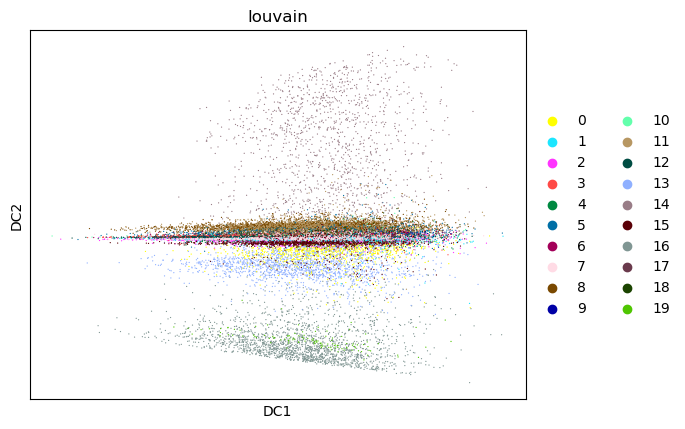

In [56]:
sc.pl.diffmap(tdata, color="louvain_subset")

In [57]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 229 ms, sys: 2.93 ms, total: 232 ms
Wall time: 291 ms


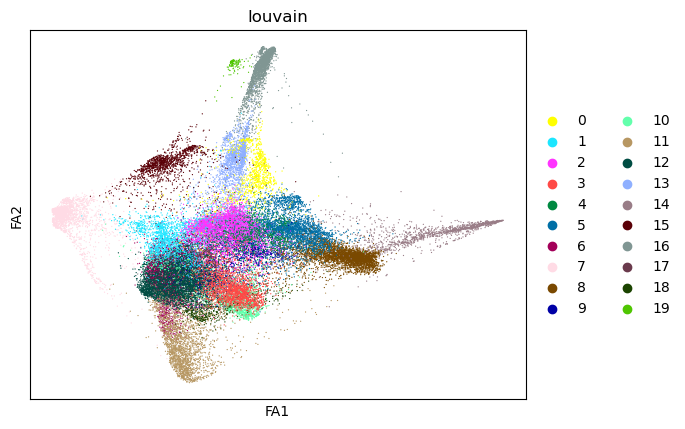

In [58]:
sc.pl.draw_graph(tdata, color="louvain_subset")

After this you can use `X_diffmap` for `sc.pp.neighbors` and other functions. 

In [59]:
print("Total Processing time: %s" % (time.time() - preprocess_start))

Total Processing time: 86.48296594619751


In [ ]:
# These notebooks are very GPU memory intensive!
# In order to free up GPU memory, we'll kill this kernel prior to proceeding.  You will get a message.  This is expected.
# If you have a CUDA or an Out Of Memory (OOM) error, please kill all kernels to free up your GPU memory and try again!
# You can comment this out if you want to continue exploring the notebook.
# Please consult the README for more tips and tricks.

import IPython

IPython.Application.instance().kernel.do_shutdown(True)